# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix

from utils import *

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set options for displaying dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))

# 2. Load data & Basic information

In [3]:
ins = load_data('dseb63_installments_payments.csv',
                filename_train='dseb63_application_train.csv',
                filename_test='dseb63_application_test.csv',
                verbose=3)

Table: dseb63_installments_payments.csv
Shape: (7744758, 8)

Number of categorical variables: 0
Number of numerical variables: 8

Number of unique values of SK_ID_CURR: 180733
Number of unique values of SK_ID_PREV: 549020

Number of duplicate values: 0

Shape of train set: (246009, 123)
Number of overlapping SK_ID_CURR in dseb63_installments_payments.csv and dseb63_application_train.csv: 144408

Shape of test set: (61502, 122)
Number of overlapping SK_ID_CURR in dseb63_installments_payments.csv and dseb63_application_test.csv: 36325


,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR,TARGET
0,1054186,1.00,6,-1180.00,-1187.00,6948.36,6948.36,147397.00,0.00
1,2452854,1.00,21,-546.00,-552.00,11302.60,11302.60,147397.00,0.00
2,1054186,1.00,2,-1300.00,-1307.00,6948.36,6948.36,147397.00,0.00
3,1682318,1.00,2,-240.00,-243.00,7374.51,7374.51,147397.00,0.00
4,2452854,1.00,10,-876.00,-882.00,11302.60,11302.60,147397.00,0.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SK_ID_PREV              7744758 non-null  int64  
 1   NUM_INSTALMENT_VERSION  7744758 non-null  float64
 2   NUM_INSTALMENT_NUMBER   7744758 non-null  int64  
 3   DAYS_INSTALMENT         7744758 non-null  float64
 4   DAYS_ENTRY_PAYMENT      7743119 non-null  float64
 5   AMT_INSTALMENT          7744757 non-null  float64
 6   AMT_PAYMENT             7743119 non-null  float64
 7   SK_ID_CURR              7744757 non-null  float64
 8   TARGET                  6190746 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 531.8 MB


### Observation
- The table has 8 unique features, 6 of which describe the statistics of each installment for previous loan.
- There are 549020 unique previous loans in the installments_payments. These belong to 180733 unique SK_ID_CURR, which are ID of applicants of current loan.
- Out of these 180733 SK_ID_CURR, 144408 belong to the training dataset, and 36325 belong to the test dataset.

# 3. Target column

In [4]:
ins.TARGET.value_counts(dropna=False)

TARGET
0.00    5716893
NaN     1554012
1.00     473853
Name: count, dtype: int64

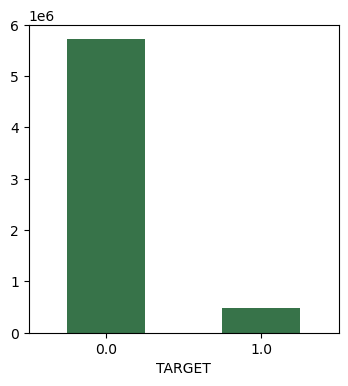

In [5]:
ins.TARGET.value_counts().plot.bar(color='#377349', figsize=(4,4), rot=0);

### Observation
- Most of the loans were paid back on time
- There are 1554012 records not having TARGET

# 4. Missing values

In [6]:
df_missing = create_df_missing(ins)
df_missing[df_missing.num_missing > 0]

,num_missing,pct_missing
TARGET,1554012,20.07
DAYS_ENTRY_PAYMENT,1639,0.02
AMT_PAYMENT,1639,0.02
AMT_INSTALMENT,1,0.00
SK_ID_CURR,1,0.00


### Observation
- There are only 4 columns which contain NaN values of the 8 columns from installments_payments.
- These columns also contain very minimal proportion of NaN values, i.e only 0.02%, so it is not of much concern.

# 5. Define numeric and category features

In [7]:
ins, cate_ins, num_ins = validate_dtype(ins)

# 6. Imbalanced class

No categorical features

# 7. Outlier

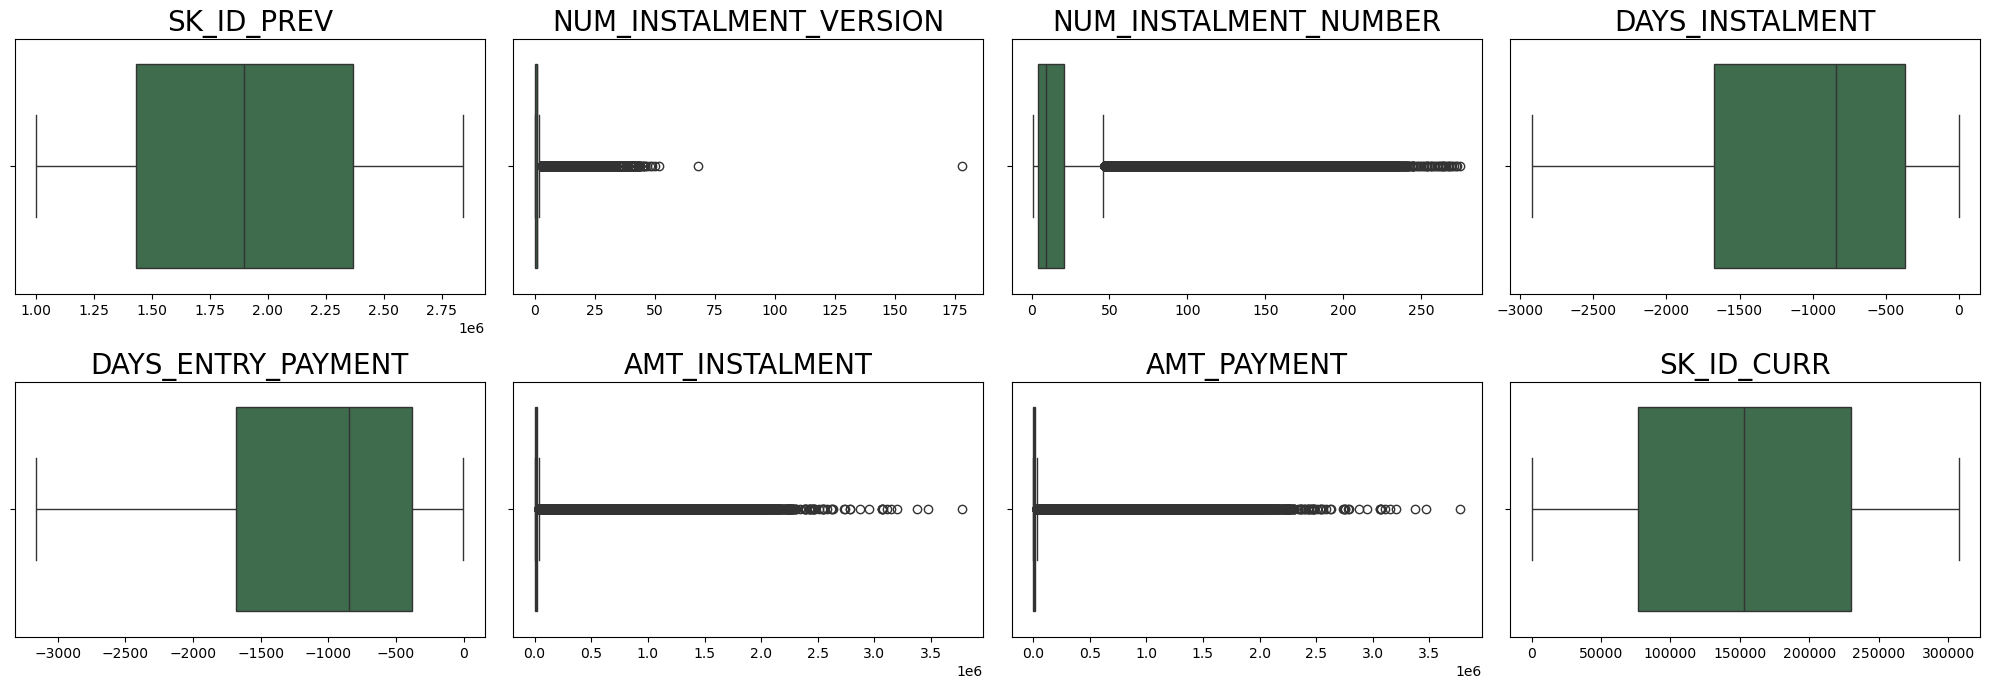

In [8]:
plot_boxplot(num_ins, figsize=(20, 10))

### Observation
Most features have many outliers and skewed distributions

# 8. Anomalies
There is no anomaly in this data

# 9. Correlation
This dataset has no categorical features

In [9]:
cmat = CorrelationMatrix(ins, drop_cols=['SK_ID_CURR', 'SK_ID_PREV'])

In [10]:
cmat.target_top()

,PhiK-Correlation
AMT_INSTALMENT,0.72
AMT_PAYMENT,0.67
DAYS_ENTRY_PAYMENT,0.05
DAYS_INSTALMENT,0.04
NUM_INSTALMENT_NUMBER,0.02
NUM_INSTALMENT_VERSION,0.01


## Numerical values

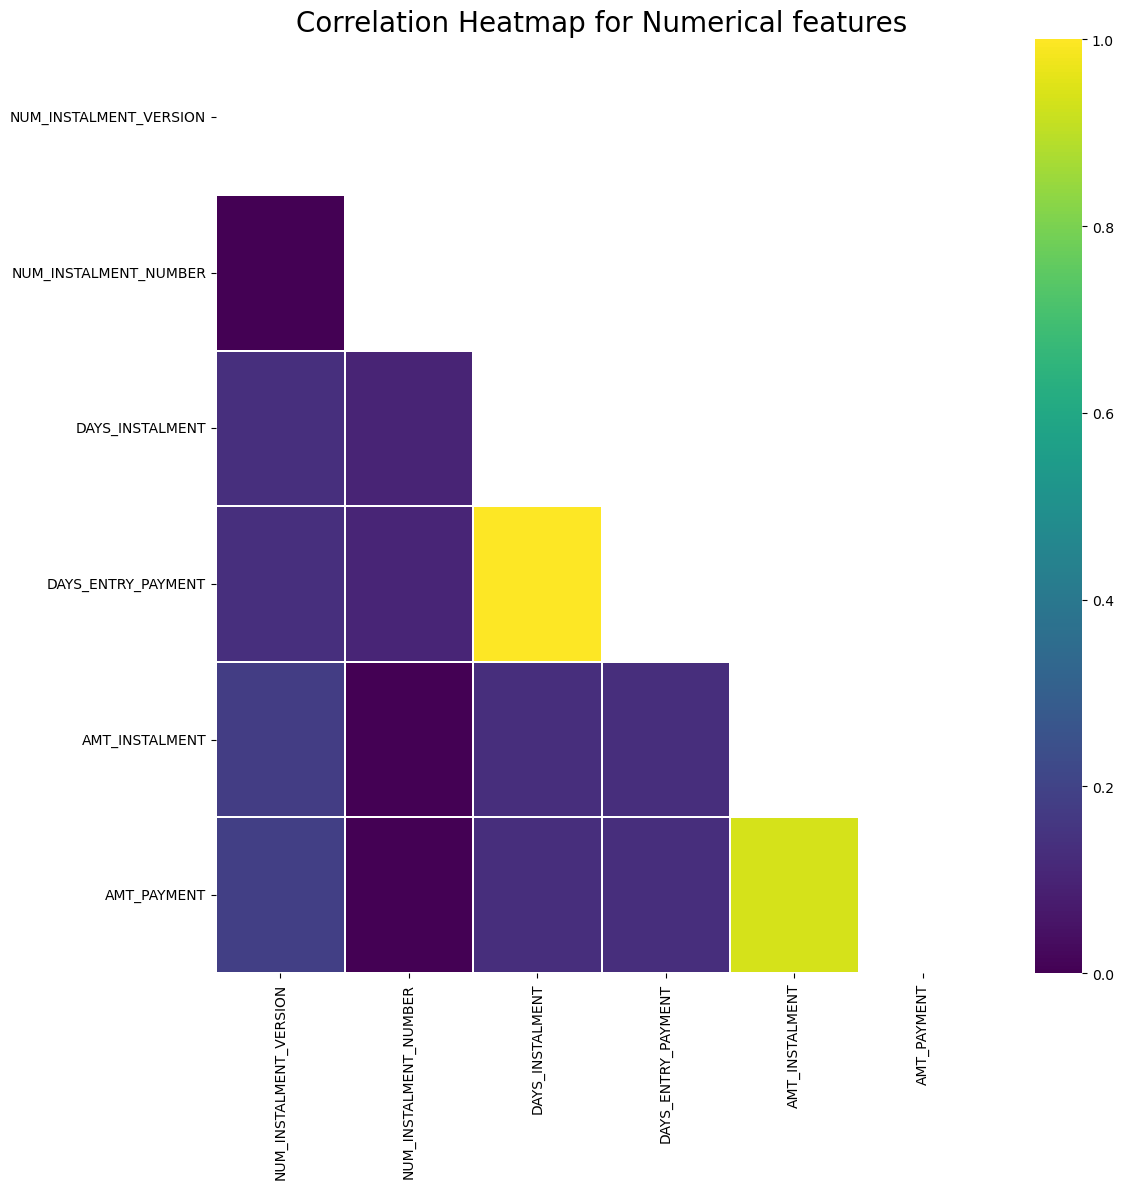

In [11]:
cmat.plot_correlation_matrix()

In [12]:
cmat.target_top_num()

,Correlation
DAYS_ENTRY_PAYMENT,0.03
DAYS_INSTALMENT,0.03
NUM_INSTALMENT_NUMBER,0.02
NUM_INSTALMENT_VERSION,0.01
AMT_PAYMENT,0.00
AMT_INSTALMENT,0.00


### Observation
- From the heatmap of correlation matrix, we see a couple of highly correlated features. These are:
    + AMT_INSTALMENT and AMT_PAYMENT
    + DAYS_INSTALMENT and DAYS_ENTRY_PAYMENT
- These two sets of correlated features are understandable, as they are actually the features as to when the installment was due to be paid vs when it was paid and also the amount that was due vs the amount that was paid.

# 10. Numerical analysis
Firstly we will group by the 'SK_ID_PREV' field and aggregate with mean, so that we get an averaged row for each of the previous loan that the client had.

In [13]:
ins_mean = ins.groupby('SK_ID_PREV').mean()

## 10.1 DAYS_INSTALMENT

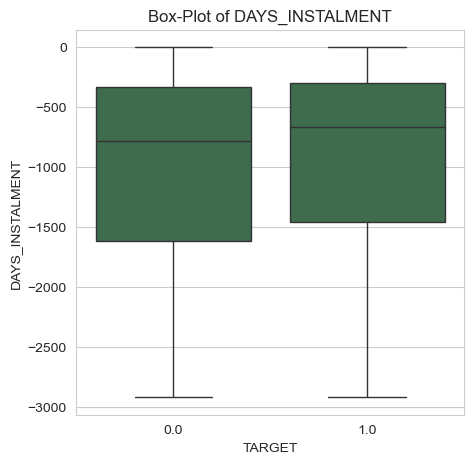

In [14]:
plot_continuous_variables(ins_mean, 'DAYS_INSTALMENT', plots = ['box'], figsize=(5,5))


This column lists the days when the installment of previous credit was actually paid.

## 10.2 DAYS_ENTRY_PAYMENT

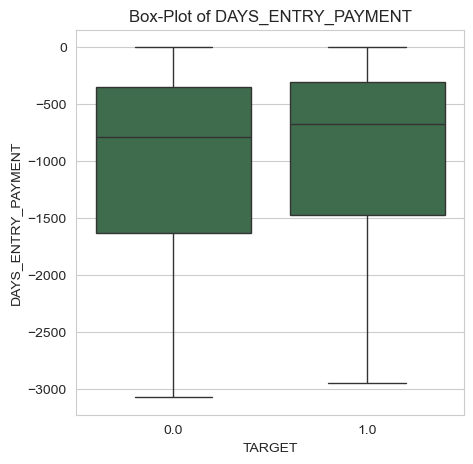

In [15]:
plot_continuous_variables(ins_mean, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize=(5,5))

### Observation
From the above two plots, we can see a similar pattern, where the Defaulters tend to have lesser number of days since their last payment, while Non-Defaulters have more number of days since their last payments. All quantiles of Defaulters have more recent days than those of Non-Defaulters. Thus, Non-Defaulters usually have more gap in their payments from the day of application as compared to Defaulters.